### Data Collection & Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import time
import os
import shutil
import numpy as np
import torch
import random

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torchvision.datasets as datasets


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Data Processing and Augmentation

In [ ]:
# Define a custom transformation for rotation of 45 degrees with 50% chance
class RandomRotation(object):
    def __call__(self, img):
        if random.random() < 0.5:
            return img.rotate(45)
        return img

In [ ]:
data_dir = "/content/gdrive/My Drive/APS360 Project Dataset/all_data"
# Load and transform data using ImageFolder
# Compose transformations: RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
data_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    RandomRotation(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0],std=[1])
])
all_data = datasets.ImageFolder(data_dir, transform=data_transform)

# for images, _ in data_loader:
#   print(images.shape)
#   print(images)
#   break


Data Augmentation: For each image there will be a 50% chance of horizontal inversion,
and a 50% chance of a rotation of 45 degrees. Additionally we will normalize each image along
each of the R, G, and B channels to have a mean of zero and a variance of one, centering the data on
0.

Visualize Some Data

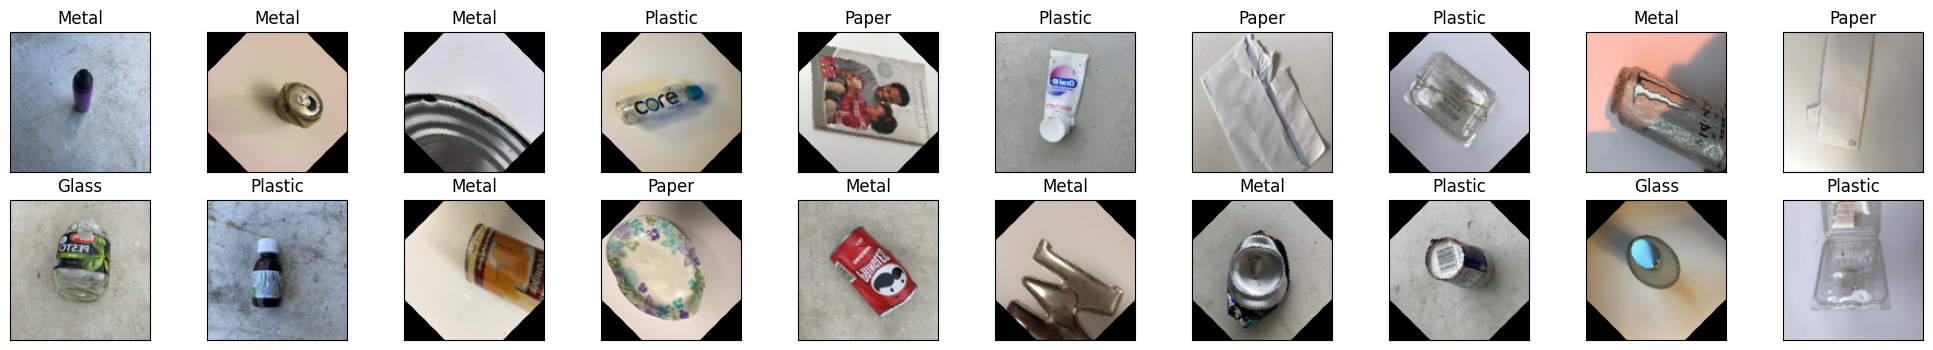

In [ ]:
#define waste classes - folders in each directory with these names
classes = ['Glass', 'Metal', 'Paper', 'Plastic']

data_loader = torch.utils.data.DataLoader(all_data, batch_size=20,
                                           num_workers=1, shuffle=True)
# obtain one batch of training images
dataiter = iter(data_loader)
images, labels = next(dataiter)

#print(labels)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])  # Use class_names instead of classes

#Splitting Data In Train-Valid-Test

Ideally, we want a balanced dataset with an even amount of images in each class. We choose to use the class with the least amount of data for all classes and split the data into the training, validation, and test sets accordingly. For the test set, in addition to using the sample data, it will also contain new data taken by the students.

In [ ]:
def countFiles(path):
    num_items = 0
    for _,_,files in os.walk(path):
        num_items += len(files)
    return num_items

glass_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Glass"
metal_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Metal"
paper_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Paper"
plastic_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Plastic"
glass = countFiles(glass_path)
metal = countFiles(metal_path)
paper = countFiles(paper_path)
plastic = countFiles(plastic_path)
print("Number of Glass:", glass)
print("Number of Metal:", metal)
print("Number of Paper:", paper)
print("Number of Plastic:", plastic)

Number of Glass: 928
Number of Metal: 976
Number of Paper: 940
Number of Plastic: 949


Given that the Glass category contains the minimum number of images, we aim to leave around 900+ samples in each. This will reduce any biases and allow our model to generalize better, leading to more accurate results. As we had issues obtaining the token to use the Google Drive API, this was done manually by deleting random photos from each class

In [ ]:
glass_new = countFiles(glass_path)
metal_new = countFiles(metal_path)
paper_new = countFiles(paper_path)
plastic_new = countFiles(plastic_path)
print("Number of Glass:", glass_new)
print("Number of Metal:", metal_new)
print("Number of Paper:", paper_new)
print("Number of Plastic:", plastic_new)

Number of Glass: 928
Number of Metal: 976
Number of Paper: 940
Number of Plastic: 949


### Train-Val-Test Ratios
A 70-15-15 split was selected to split our data (with slightly more images in the test as wish to test the photos taken ourselves on the final model). This will ensure that there is a sufficient amount of data for the model to train on without risk of overfitting during hyperparameter tuning, and also leaves enough to show the final, unbiased results when we test the baseline.

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input = '/content/gdrive/My Drive/APS360 Project Dataset/all_data'
splitData = '/content/gdrive/My Drive/APS360 Project Dataset/split_data'
# split data to train, val, and test into 70%, 15% and 15%, respectively
# as we are adding in our own pictures to the test set, the ratios will be slightly different to accomodate for this
#splitfolders.ratio(input, output=splitData, seed=1, ratio=(.7, .155, .145), group_prefix=None)

Copying files: 3793 files [01:15, 50.16 files/s]


### Building ANN

ANN Structure & Explanation:
Using Tutorial 2 (Multi-Class ANN) modified the 3-layer ANN with ReLU activation functions applied on the first and second hidden layers. The softmax activation will be used for outputting class probabilities and is not included in the architecture setup.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

class ANNWasteClassifier(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier, self).__init__()
        self.layer1 = nn.Linear(3*128*128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 4) #output is 4 classes
    def forward(self, img):
        # Determine the batch size dynamically
        #batch_size = img.size(0)
        flattened = img.view(-1, 3*128*128)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

model = ANNWasteClassifier()

print('done')

done


#### Defining Data Loaders

In [ ]:
train_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/train"
val_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/val"
test_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/test"
#For original ANN Model
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

train_loader = torch.utils.data.DataLoader(train_data, num_workers=4, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, num_workers=4, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,num_workers=4, shuffle=True)
print(len(train_loader))
print(len(val_loader))


Num training images:  2654
Num validation images:  586
Num testing images:  553
83
19


Training Code

In [ ]:
def get_accuracy(model, loader, device):
    """Compute the accuracy of the model."""
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [74]:
from torch.optim.lr_scheduler import StepLR

def train(model, train_loader, valid_loader, device, num_epochs=10, learning_rate=0.001):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) #each update, how much memory
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # LR scheduler

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    # Keep track of the best validation loss and accuracy
    best_valid_loss = float('inf')
    best_valid_acc = 0
    for epoch in range(num_epochs):
      model.train()
      total_train_loss, total_train_correct = 0, 0
      for imgs, labels in train_loader:
        #print(imgs.shape)
        #print(labels.shape)
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_correct += (predicted == labels).sum().item()

      # Learning rate scheduler step
      scheduler.step()

      # Calculate average training loss for the epoch
      train_loss = total_train_loss / len(train_loader)
      train_acc = total_train_correct / len(train_loader.dataset)
      train_losses.append(train_loss)
      train_accs.append(train_acc)
      # Set model to evaluation mode
      model.eval()
      total_valid_loss, total_valid_correct = 0, 0

      with torch.no_grad():
          for images, labels in valid_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)

              total_valid_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total_valid_correct += (predicted == labels).sum().item()

      avg_valid_loss = total_valid_loss / len(valid_loader)
      valid_accuracy = total_valid_correct / (len(valid_loader.dataset))
      val_losses.append(avg_valid_loss)
      val_acc = get_accuracy(model, valid_loader, device)
      val_accs.append(val_acc)
      # Update best validation loss and accuracy
      if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          best_valid_acc = valid_accuracy

      print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}')

    plot_training_curve(train_losses, val_losses, train_accs, val_accs)

print('done')


done


In [ ]:
def plot_training_curve(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation losses and accuracies."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Checking accuracy on small batch


In [ ]:
'''#debug_data = datasets.ImageFolder(data_dir, transform=data_transform)
model = ANNWasteClassifier()
#print(f"Model batch size: {next(model.parameters()).shape[0]}")
#print(f"Data batch size: {next(iter(debug_data))[0].shape[0]}")
train(model, train_data, batch_size = 1, num_epochs=10, print_stat=1)'''

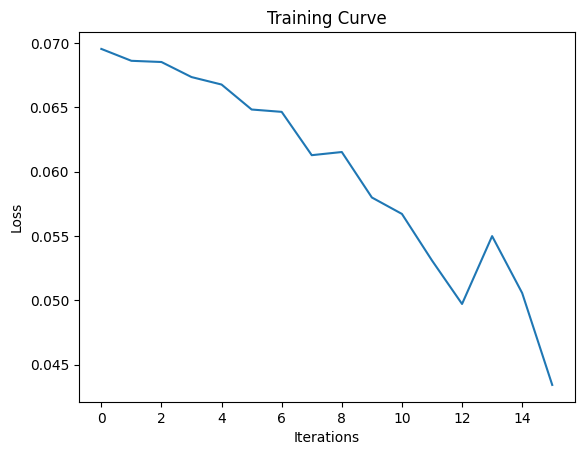

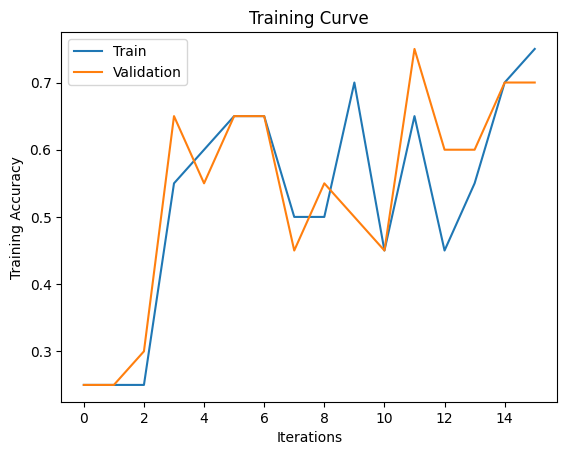

Final Training Accuracy: 0.75
Final Validation Accuracy: 0.7


In [ ]:
'''#proper model
data_dir = "/content/gdrive/My Drive/APS360 Project Dataset/mini trainset/"
debug_data = datasets.ImageFolder(data_dir, transform=data_transform)
model = ANNWasteClassifier()
train(model, debug_data, batch_size=20, num_epochs=16)'''

image dimensions:  torch.Size([3, 128, 128])
output dimensions:  torch.Size([1, 4])
output probabilities:  tensor([[0.2377, 0.2540, 0.2604, 0.2480]], grad_fn=<SoftmaxBackward0>) sum:  tensor(1., grad_fn=<SumBackward0>)
output:  2 with a probability of 0.26035770773887634
label:  tensor(2)


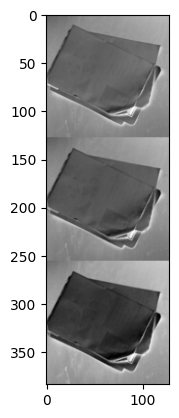

In [ ]:
debug_loader = torch.utils.data.DataLoader(debug_data, batch_size=20,
                                           num_workers=1, shuffle=True)
for images, labels in debug_loader:
    # Get the first image from the batch
    image = images[0]
    label = labels[0]
    break  # Break after fetching the first batch
#plot sample image
print('image dimensions: ', image.shape)
plt.imshow(image.view(-1,128),cmap='Greys') #make image 128 x 128 (not 1 x 28 x 28 as required by model)

#test new image
out = model(image)
prob = F.softmax(out, dim=1)
print('output dimensions: ', out.shape)
print('output probabilities: ', prob, 'sum: ', torch.sum(prob))

#print max index and compare with label
print('output: ', prob.max(1, keepdim=True)[1].item(), 'with a probability of', prob.max(1, keepdim=True)[0].item())
print('label: ', label)

On a small set of sample data, the model is able to accurately predict the image. One thing to notice is that the probabilities between classes are very close to each other.

### Training on Dataset

Initial training on 128x128 due to issues with getting the model to work.

Epoch 1, Train Loss: 1.3874, Train Acc: 0.2494, Validation Acc: 0.3328
Epoch 2, Train Loss: 1.3695, Train Acc: 0.3180, Validation Acc: 0.3959
Epoch 3, Train Loss: 1.3450, Train Acc: 0.3610, Validation Acc: 0.3976
Epoch 4, Train Loss: 1.3189, Train Acc: 0.3892, Validation Acc: 0.3874
Epoch 5, Train Loss: 1.3046, Train Acc: 0.3855, Validation Acc: 0.3942
Epoch 6, Train Loss: 1.3002, Train Acc: 0.3851, Validation Acc: 0.3908
Epoch 7, Train Loss: 1.2836, Train Acc: 0.3919, Validation Acc: 0.4078
Epoch 8, Train Loss: 1.2875, Train Acc: 0.3998, Validation Acc: 0.4249
Epoch 9, Train Loss: 1.2621, Train Acc: 0.4088, Validation Acc: 0.4232
Epoch 10, Train Loss: 1.2690, Train Acc: 0.4054, Validation Acc: 0.3993
Epoch 11, Train Loss: 1.2449, Train Acc: 0.4182, Validation Acc: 0.4096
Epoch 12, Train Loss: 1.2367, Train Acc: 0.4220, Validation Acc: 0.4096
Epoch 13, Train Loss: 1.2380, Train Acc: 0.4235, Validation Acc: 0.4113
Epoch 14, Train Loss: 1.2358, Train Acc: 0.4182, Validation Acc: 0.4078
E

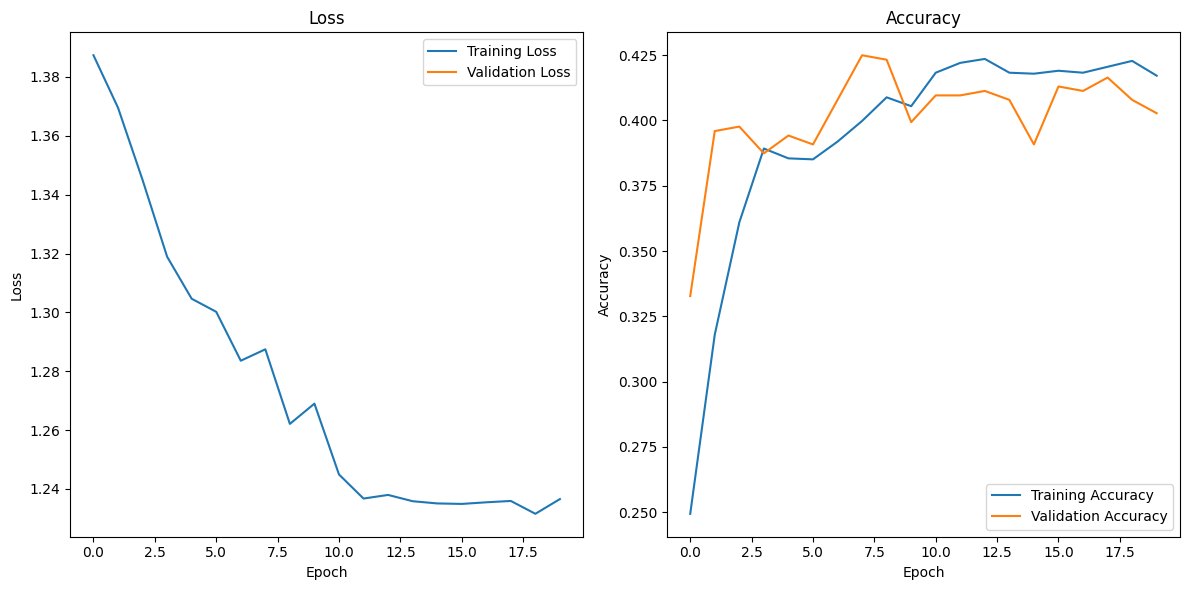

In [ ]:
model = ANNWasteClassifier().to(device)

train(model, train_loader, val_loader, device, 20, 0.001)

As we were running into issues training, we first started with the smaller image sizes until it was working. Due to computational resources and the large dataset for training, we selected 20 epochs and a 0.001 learning rate as our initial hyperparameters. Our training code utilizes a Learning Rate scheduler. This scheduler decreases the learning rate by a factor (gamma) every step_size epochs. For example, if gamma=0.1 and step_size=10, the learning rate will be decreased by a factor of 0.1 every 10 epochs.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.layer1 = nn.Linear(3*256*256, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 4) #output is 4 classes
    def forward(self, img):
        # Determine the batch size dynamically
        #batch_size = img.size(0)
        flattened = img.view(-1, 3*256*256)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output
print('done')
data_transform256 = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    RandomRotation(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0],std=[1])
])

train_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/train"
val_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/val"
test_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/test"
#For original ANN Model
train_data256 = datasets.ImageFolder(train_dir, transform=data_transform256)
val_data256 = datasets.ImageFolder(val_dir, transform=data_transform256)
test_data256 = datasets.ImageFolder(test_dir, transform=data_transform256)

# print out some stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

train_loader256 = torch.utils.data.DataLoader(train_data256, batch_size=64, num_workers=4, shuffle=True)
val_loader256 = torch.utils.data.DataLoader(val_data256,  batch_size=64, num_workers=4, shuffle=True)
test_loader256 = torch.utils.data.DataLoader(test_data256, batch_size=64,num_workers=4, shuffle=True)
print(len(train_loader))
print(len(val_loader))

done
Num training images:  2654
Num validation images:  586
Num testing images:  553
83
19


Epoch 1, Train Loss: 1.3890, Train Acc: 0.2781, Validation Acc: 0.3208
Epoch 2, Train Loss: 1.3519, Train Acc: 0.3402, Validation Acc: 0.3874
Epoch 3, Train Loss: 1.3377, Train Acc: 0.3391, Validation Acc: 0.4027
Epoch 4, Train Loss: 1.3108, Train Acc: 0.3783, Validation Acc: 0.3737
Epoch 5, Train Loss: 1.2962, Train Acc: 0.3749, Validation Acc: 0.4061
Epoch 6, Train Loss: 1.3193, Train Acc: 0.3662, Validation Acc: 0.3754
Epoch 7, Train Loss: 1.2930, Train Acc: 0.3881, Validation Acc: 0.4044
Epoch 8, Train Loss: 1.2862, Train Acc: 0.3934, Validation Acc: 0.4113
Epoch 9, Train Loss: 1.2594, Train Acc: 0.3971, Validation Acc: 0.4096
Epoch 10, Train Loss: 1.2625, Train Acc: 0.4084, Validation Acc: 0.4215
Epoch 11, Train Loss: 1.2417, Train Acc: 0.4213, Validation Acc: 0.4113
Epoch 12, Train Loss: 1.2270, Train Acc: 0.4246, Validation Acc: 0.4181
Epoch 13, Train Loss: 1.2284, Train Acc: 0.4213, Validation Acc: 0.4078
Epoch 14, Train Loss: 1.2271, Train Acc: 0.4265, Validation Acc: 0.4232
E

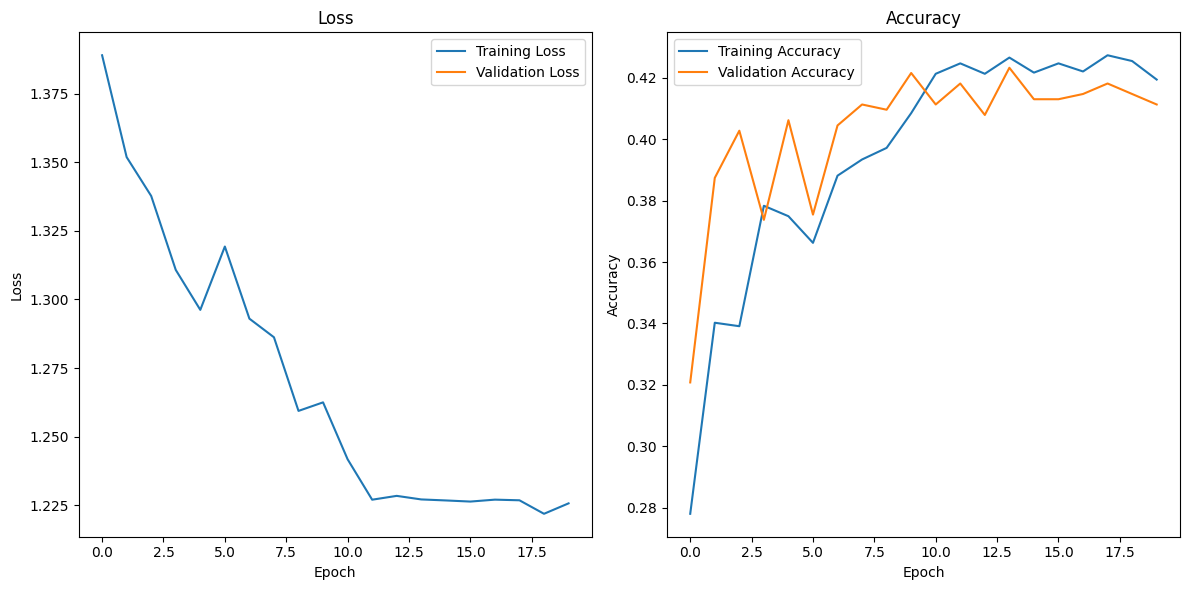

In [ ]:
model256 = ANNWasteClassifier256().to(device)
train(model256, train_loader256, val_loader256, device, 20, 0.001)

Prior to hyperparameter tuning, we decided to include batch normalization to our hidden layers to improve stability and speed up the training process.

In [ ]:
class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.layer1 = nn.Linear(3*256*256, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 4) #output is 4 classes
    def forward(self, img):
        # Determine the batch size dynamically
        #batch_size = img.size(0)
        flattened = img.view(-1, 3*256*256)
        activation1 = F.relu(self.bn1(self.layer1(flattened)))
        activation2 = F.relu(self.bn2(self.layer2(activation1)))
        output = self.layer3(activation2)
        return output

Epoch 1, Train Loss: 1.3103, Train Acc: 0.3768, Validation Acc: 0.4352
Epoch 2, Train Loss: 1.2463, Train Acc: 0.4344, Validation Acc: 0.4266
Epoch 3, Train Loss: 1.2151, Train Acc: 0.4574, Validation Acc: 0.4744
Epoch 4, Train Loss: 1.1815, Train Acc: 0.4665, Validation Acc: 0.4744
Epoch 5, Train Loss: 1.1602, Train Acc: 0.4894, Validation Acc: 0.5222
Epoch 6, Train Loss: 1.1244, Train Acc: 0.5124, Validation Acc: 0.4795
Epoch 7, Train Loss: 1.1195, Train Acc: 0.5151, Validation Acc: 0.4795
Epoch 8, Train Loss: 1.1024, Train Acc: 0.5181, Validation Acc: 0.5154
Epoch 9, Train Loss: 1.0802, Train Acc: 0.5554, Validation Acc: 0.4983
Epoch 10, Train Loss: 1.0662, Train Acc: 0.5482, Validation Acc: 0.4915
Epoch 11, Train Loss: 1.0273, Train Acc: 0.5791, Validation Acc: 0.5427
Epoch 12, Train Loss: 1.0004, Train Acc: 0.5972, Validation Acc: 0.5802
Epoch 13, Train Loss: 1.0043, Train Acc: 0.6017, Validation Acc: 0.5683
Epoch 14, Train Loss: 0.9926, Train Acc: 0.6055, Validation Acc: 0.5802
E

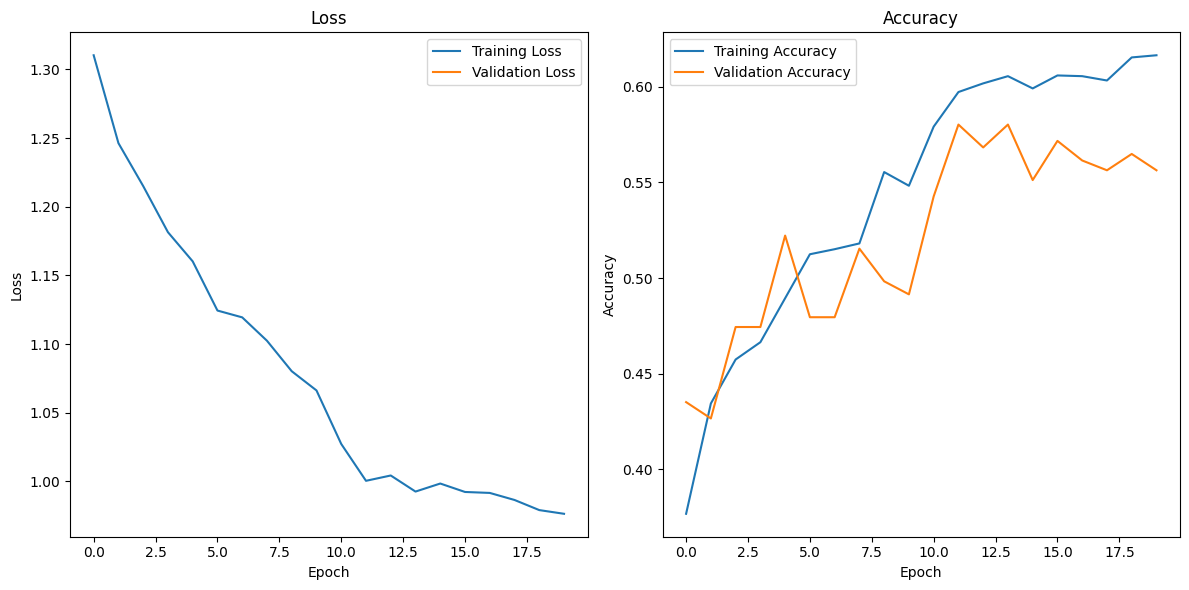

In [ ]:
model256 = ANNWasteClassifier256().to(device)
train(model256, train_loader256, val_loader256, device, 20, 0.001)

With batch normalization, accuracy approved for both the training and validation set. Now, we will start with hyperparameter tuning

# Hyperparameter Tuning

To reduce the numberof neurons in each layer in order to improve the models accuracy we will increase the nunmber of layers of the model to 5

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(1) # set the random seed

class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.layer1 = nn.Linear(3*256*256, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.layer4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear(64, 4)

    def forward(self, img):
        # Determine the batch size dynamically
        batch_size = img.size(0)

        flattened = img.view(-1, 3*256*256)
        x = F.relu(self.bn1(self.layer1(flattened)))
        x = F.relu(self.bn2(self.layer2(x)))
        x = F.relu(self.bn3(self.layer3(x)))
        x = F.relu(self.bn4(self.layer4(x)))
        output = self.layer5(x)
        return output
print('done')


done


Epoch 1, Train Loss: 1.2967, Train Acc: 0.3866, Validation Acc: 0.4386
Epoch 2, Train Loss: 1.2046, Train Acc: 0.4619, Validation Acc: 0.4795
Epoch 3, Train Loss: 1.1689, Train Acc: 0.4962, Validation Acc: 0.4642
Epoch 4, Train Loss: 1.1330, Train Acc: 0.5207, Validation Acc: 0.4983
Epoch 5, Train Loss: 1.1085, Train Acc: 0.5332, Validation Acc: 0.5017
Epoch 6, Train Loss: 1.0820, Train Acc: 0.5584, Validation Acc: 0.4846
Epoch 7, Train Loss: 1.0639, Train Acc: 0.5531, Validation Acc: 0.5358
Epoch 8, Train Loss: 1.0455, Train Acc: 0.5712, Validation Acc: 0.5273
Epoch 9, Train Loss: 1.0271, Train Acc: 0.5919, Validation Acc: 0.5410
Epoch 10, Train Loss: 1.0084, Train Acc: 0.6025, Validation Acc: 0.5478
Epoch 11, Train Loss: 0.9765, Train Acc: 0.6240, Validation Acc: 0.6058
Epoch 12, Train Loss: 0.9590, Train Acc: 0.6462, Validation Acc: 0.6007
Epoch 13, Train Loss: 0.9494, Train Acc: 0.6541, Validation Acc: 0.6007
Epoch 14, Train Loss: 0.9400, Train Acc: 0.6571, Validation Acc: 0.6092
E

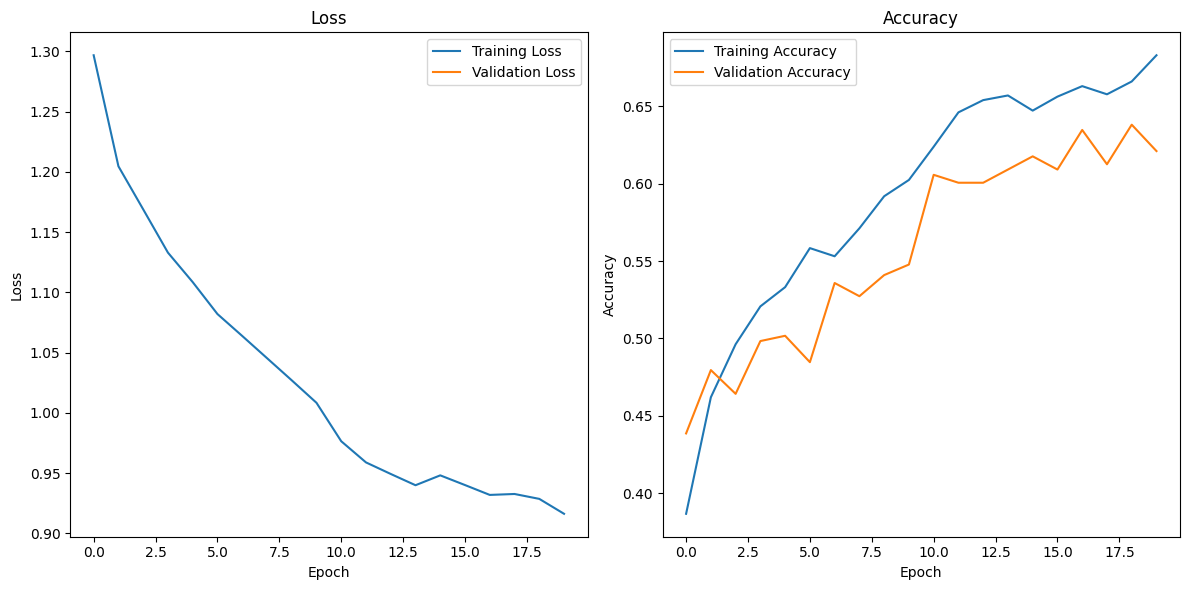

In [ ]:
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 20, 0.0001)

In order to allow the model to converge faster, we increased the number of epochs from 20 to 30/50.

Epoch 1, Train Loss: 1.2951, Train Acc: 0.3941, Validation Acc: 0.4232
Epoch 2, Train Loss: 1.1974, Train Acc: 0.4766, Validation Acc: 0.4556
Epoch 3, Train Loss: 1.1619, Train Acc: 0.5098, Validation Acc: 0.5000
Epoch 4, Train Loss: 1.1237, Train Acc: 0.5411, Validation Acc: 0.4795
Epoch 5, Train Loss: 1.0984, Train Acc: 0.5494, Validation Acc: 0.5051
Epoch 6, Train Loss: 1.0771, Train Acc: 0.5644, Validation Acc: 0.5000
Epoch 7, Train Loss: 1.0564, Train Acc: 0.5735, Validation Acc: 0.5068
Epoch 8, Train Loss: 1.0439, Train Acc: 0.5754, Validation Acc: 0.5495
Epoch 9, Train Loss: 1.0207, Train Acc: 0.6044, Validation Acc: 0.5119
Epoch 10, Train Loss: 0.9943, Train Acc: 0.6187, Validation Acc: 0.5529
Epoch 11, Train Loss: 0.9613, Train Acc: 0.6409, Validation Acc: 0.6195
Epoch 12, Train Loss: 0.9387, Train Acc: 0.6647, Validation Acc: 0.6041
Epoch 13, Train Loss: 0.9378, Train Acc: 0.6575, Validation Acc: 0.6092
Epoch 14, Train Loss: 0.9218, Train Acc: 0.6756, Validation Acc: 0.6280
E

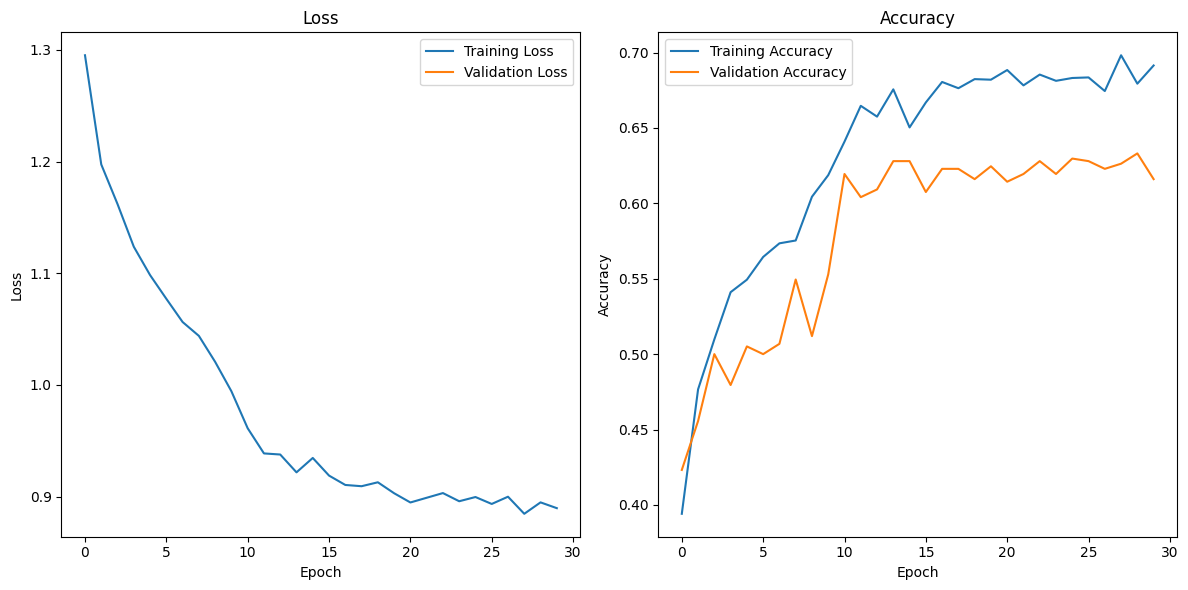

In [ ]:
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 30, 0.0001)

When setting the number of epochs to 30, the convergence was more exponential but there is still a lot of fluctuation and underfitting. To help with the fluctuation we will decrease the learning rate from 0.0001 to 0.00005. Additionally, we can decrease the number of epochs down to 25 since it plateaus and does not perform significatly better than at 25.

Learning rate of 0.00005 did not help, decreased the accuracy to 0.59 rather than before at 0.62. Try changing lr to 0.0005

at 0.0005 it got to 0.62/0.63, try 0.001

fluctuated up to 0.65, try 0.01

Did not work as well, decreased to 0.62/63. Keep at lr = 0.001

Next try increasing the number of layers since it is still underfitting. Increased from 5 layers to 6
Decreased from 0.65 to approx 0.64
Try increase another layer from 6 to 7
final output of 0.62. Use 5 layers, increase batch size to 64, 0.65 accuracy try batch size 128 final output: 0.48

Epoch 1, Train Loss: 1.3848, Train Acc: 0.2656, Validation Acc: 0.2918
Epoch 2, Train Loss: 1.3477, Train Acc: 0.3466, Validation Acc: 0.3242
Epoch 3, Train Loss: 1.3219, Train Acc: 0.3610, Validation Acc: 0.4181
Epoch 4, Train Loss: 1.2842, Train Acc: 0.3941, Validation Acc: 0.3686
Epoch 5, Train Loss: 1.2834, Train Acc: 0.3896, Validation Acc: 0.3908
Epoch 6, Train Loss: 1.3031, Train Acc: 0.3734, Validation Acc: 0.3857
Epoch 7, Train Loss: 1.2842, Train Acc: 0.3881, Validation Acc: 0.4249
Epoch 8, Train Loss: 1.2702, Train Acc: 0.3994, Validation Acc: 0.3925
Epoch 9, Train Loss: 1.2579, Train Acc: 0.4009, Validation Acc: 0.4215
Epoch 10, Train Loss: 1.2468, Train Acc: 0.4077, Validation Acc: 0.4147
Epoch 11, Train Loss: 1.2279, Train Acc: 0.4261, Validation Acc: 0.4096
Epoch 12, Train Loss: 1.2207, Train Acc: 0.4348, Validation Acc: 0.4130
Epoch 13, Train Loss: 1.2215, Train Acc: 0.4273, Validation Acc: 0.4369
Epoch 14, Train Loss: 1.2213, Train Acc: 0.4299, Validation Acc: 0.4061
E

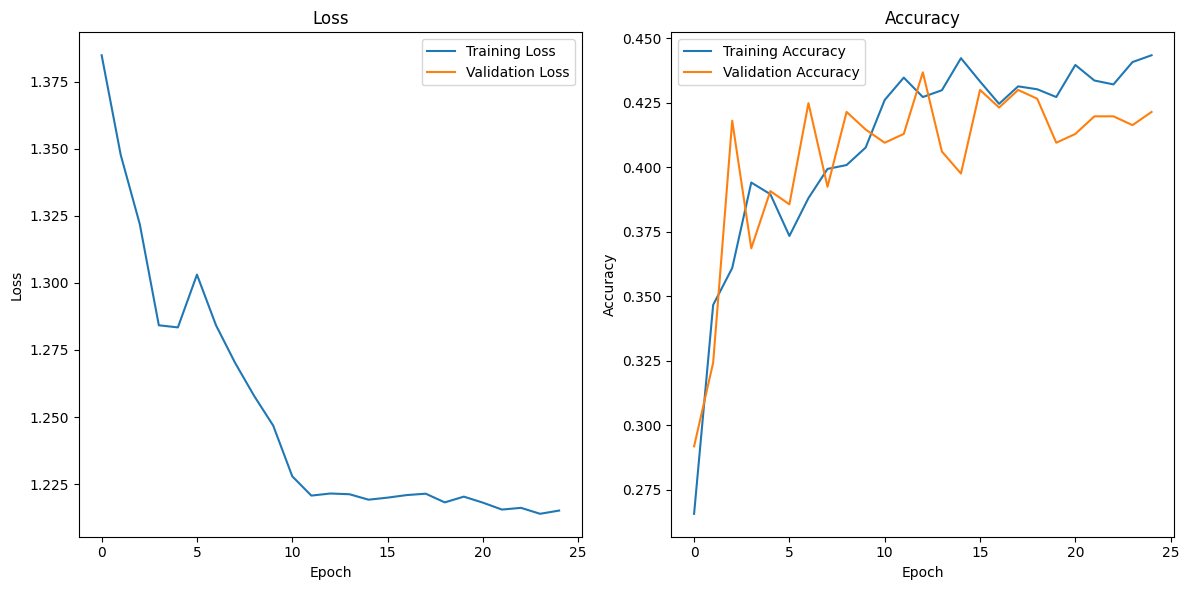

In [ ]:
#batch size
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 25, 0.001)

Epoch 1, Train Loss: 1.4296, Train Acc: 0.2999, Validation Acc: 0.2969
Epoch 2, Train Loss: 1.3619, Train Acc: 0.3331, Validation Acc: 0.3823
Epoch 3, Train Loss: 1.3308, Train Acc: 0.3610, Validation Acc: 0.3788
Epoch 4, Train Loss: 1.3030, Train Acc: 0.3753, Validation Acc: 0.4300
Epoch 5, Train Loss: 1.2923, Train Acc: 0.3896, Validation Acc: 0.4386
Epoch 6, Train Loss: 1.2704, Train Acc: 0.3896, Validation Acc: 0.4556
Epoch 7, Train Loss: 1.2583, Train Acc: 0.4099, Validation Acc: 0.4454
Epoch 8, Train Loss: 1.2557, Train Acc: 0.4103, Validation Acc: 0.4744
Epoch 9, Train Loss: 1.2457, Train Acc: 0.4228, Validation Acc: 0.4505
Epoch 10, Train Loss: 1.2378, Train Acc: 0.4197, Validation Acc: 0.4812
Epoch 11, Train Loss: 1.2244, Train Acc: 0.4239, Validation Acc: 0.4795
Epoch 12, Train Loss: 1.2211, Train Acc: 0.4295, Validation Acc: 0.4829
Epoch 13, Train Loss: 1.2290, Train Acc: 0.4318, Validation Acc: 0.4812
Epoch 14, Train Loss: 1.2165, Train Acc: 0.4209, Validation Acc: 0.4898
E

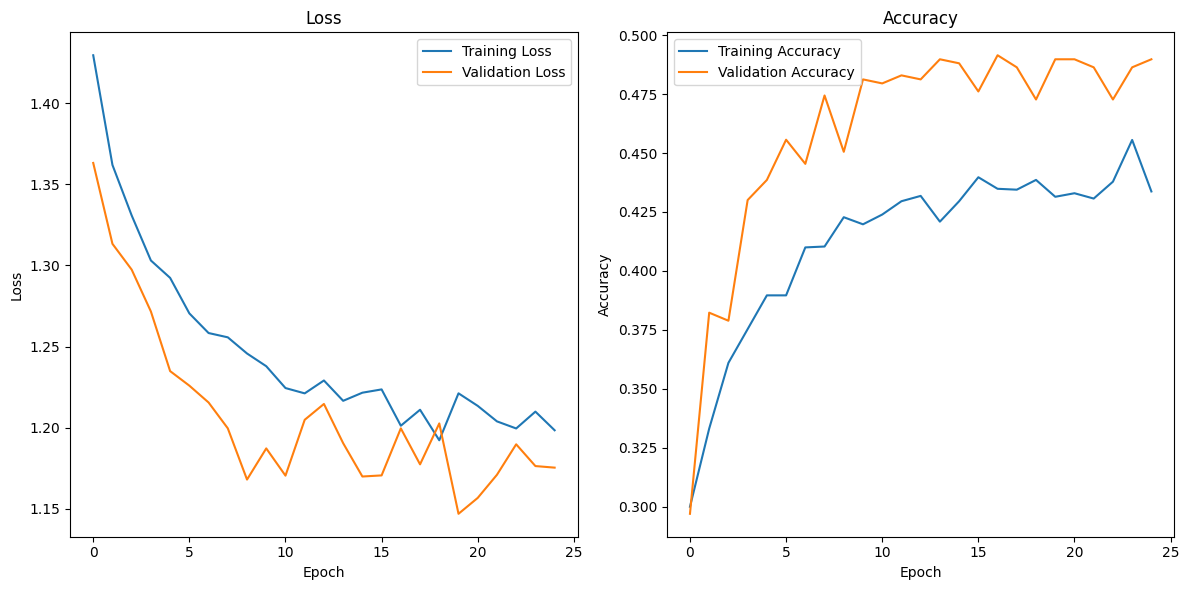

In [75]:
model256 = ANNWasteClassifier256().to(device)
#print(model256)
train(model256, train_loader256, val_loader256, device, 25, 0.001)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1) # set the random seed

class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.layer1 = nn.Linear(3*256*256, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)  # Adding dropout with a dropout rate of 0.5
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.layer4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.layer5 = nn.Linear(64, 4)

    def forward(self, img):
        # Determine the batch size dynamically
        batch_size = img.size(0)

        flattened = img.view(-1, 3*256*256)
        x = F.relu(self.bn1(self.layer1(flattened)))
        x = self.dropout1(x)  # Applying dropout after the activation function
        x = F.relu(self.bn2(self.layer2(x)))
        x = F.relu(self.bn3(self.layer3(x)))
        x = F.relu(self.bn4(self.layer4(x)))
        x = self.dropout2(x)
        output = self.layer5(x)
        return output

print('done')


done


In [ ]:
model256 = ANNWasteClassifier256().to(device)
#print(model256)
train(model256, train_loader256, val_loader256, device, 40, 0.001)

UnboundLocalError: local variable 'best_valid_loss' referenced before assignment

To help improve the validation accuracy and reduce underfitting, we implemented dropout to the ann

### Best Model

# Testing Baseline

### OLD STUFF

original baseline poorly trains. dataset is too large. apply batch normalization and increase number of layers to reduce the number of neurons for more effective learning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(1) # set the random seed

class ANNWasteClassifier2(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier2, self).__init__()
        self.layer1 = nn.Linear(3*128*128, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.layer4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear(64, 4)

    def forward(self, img):
        # Determine the batch size dynamically
        batch_size = img.size(0)

        flattened = img.view(-1, 3*128*128)
        x = F.relu(self.bn1(self.layer1(flattened)))
        x = F.relu(self.bn2(self.layer2(x)))
        x = F.relu(self.bn3(self.layer3(x)))
        x = F.relu(self.bn4(self.layer4(x)))
        output = self.layer5(x)
        return output
print('done')


done


Epoch 1, Train Loss: 1.3410, Train Acc: 0.3346, Validation Acc: 0.4215
Epoch 2, Train Loss: 1.2181, Train Acc: 0.4307, Validation Acc: 0.4061
Epoch 3, Train Loss: 1.1893, Train Acc: 0.4661, Validation Acc: 0.4898
Epoch 4, Train Loss: 1.1383, Train Acc: 0.5075, Validation Acc: 0.4744
Epoch 5, Train Loss: 1.1092, Train Acc: 0.5369, Validation Acc: 0.4966
Epoch 6, Train Loss: 1.0876, Train Acc: 0.5543, Validation Acc: 0.5222
Epoch 7, Train Loss: 1.0684, Train Acc: 0.5716, Validation Acc: 0.5256
Epoch 8, Train Loss: 1.0465, Train Acc: 0.5791, Validation Acc: 0.5188
Epoch 9, Train Loss: 1.0244, Train Acc: 0.5946, Validation Acc: 0.5273
Epoch 10, Train Loss: 0.9991, Train Acc: 0.6247, Validation Acc: 0.5631
Epoch 11, Train Loss: 0.9868, Train Acc: 0.6232, Validation Acc: 0.5939
Epoch 12, Train Loss: 0.9706, Train Acc: 0.6428, Validation Acc: 0.6143
Epoch 13, Train Loss: 0.9572, Train Acc: 0.6545, Validation Acc: 0.6024
Epoch 14, Train Loss: 0.9395, Train Acc: 0.6639, Validation Acc: 0.5785
E

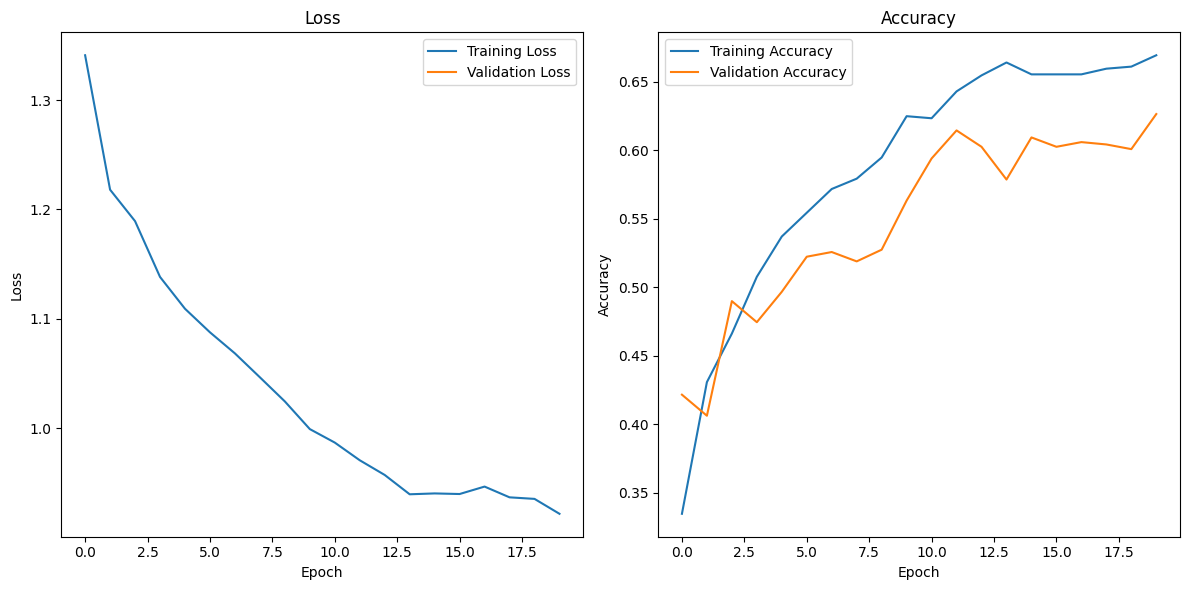

In [ ]:
model = ANNWasteClassifier2().to(device)

train(model, train_loader, val_loader, device, 20, 0.0001)